#### Dependencies

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab and Kaggle notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
    !pip install --no-deps cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [2]:
import unsloth
from unsloth import FastVisionModel  # FastLanguageModel for LLMs

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/frank/nexcar-challenge/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from transformers import TextStreamer
import re

#### Hyperparameters

In [4]:
DATA_DIR = "data"

In [5]:
# Hyperparameters
NUM_FRAMES = 5  # Number of frames to extract from the video
TIME_BETWEEN_FRAMES = 1  # Time between frames in seconds

#### Load Data

In [6]:
train_csv_path = f"{DATA_DIR}/train.csv"
train_videos_folder = f"{DATA_DIR}/train/"

df = pd.read_csv(train_csv_path)
df.head()

,id,time_of_event,time_of_alert,target
0,1924,NaN,NaN,0
1,822,19.5,18.633,1
2,1429,NaN,NaN,0
3,208,19.8,19.233,1
4,1904,NaN,NaN,0


In [7]:
class ImageDataset(Dataset):
    def __init__(self, data, videos_folder, transform=None):
        self.data = data
        self.videos_folder = videos_folder
        self.transform = transform  # Any image transformations (e.g., augmentations)
        self.num_frames = NUM_FRAMES
        self.time_between_frames = TIME_BETWEEN_FRAMES

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        vid_path = os.path.join(
            self.videos_folder, f"{str(int(row['id'])).zfill(5)}.mp4"
        )

        time = None if np.isnan(row["time_of_event"]) else row["time_of_event"]
        images = self.get_multiple_frames(vid_path, time)

        label = row["target"]

        # Apply transformations
        if self.transform:
            images = [self.transform(image) for image in images]

        return images, torch.tensor(label), row["id"]  # Convert label to tensor

    def get_frame(self, video_path, time):
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_MSEC, time * 1000)

        success, frame = cap.read()
        cap.release()

        if not success:
            raise ValueError(f"Failed to read frame at {time} seconds.")

        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        return Image.fromarray(frame)

    def get_multiple_frames(self, video_path, time):
        time_between_frames = self.time_between_frames

        if time == 0:
            # Get the first frame
            frame = self.get_frame(video_path, time)
            return [frame]

        if time is None:
            # Get the last frames
            cap = cv2.VideoCapture(video_path)
            frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT) - 1
            fps = cap.get(cv2.CAP_PROP_FPS)
            time = frame_count / fps
            cap.release()

        frames = []
        for i in range(self.num_frames):
            try:
                frame = self.get_frame(video_path, time - i * time_between_frames)
                frames.append(frame)
            except ValueError:
                break
        return frames


transform = transforms.Compose(
    [
        transforms.Resize((480, 854)),  # Resize to a standard size
    ]
)

In [8]:
train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["target"]
)

train_dataset = ImageDataset(train_df, train_videos_folder, transform=transform)
val_dataset = ImageDataset(val_df, train_videos_folder, transform=transform)

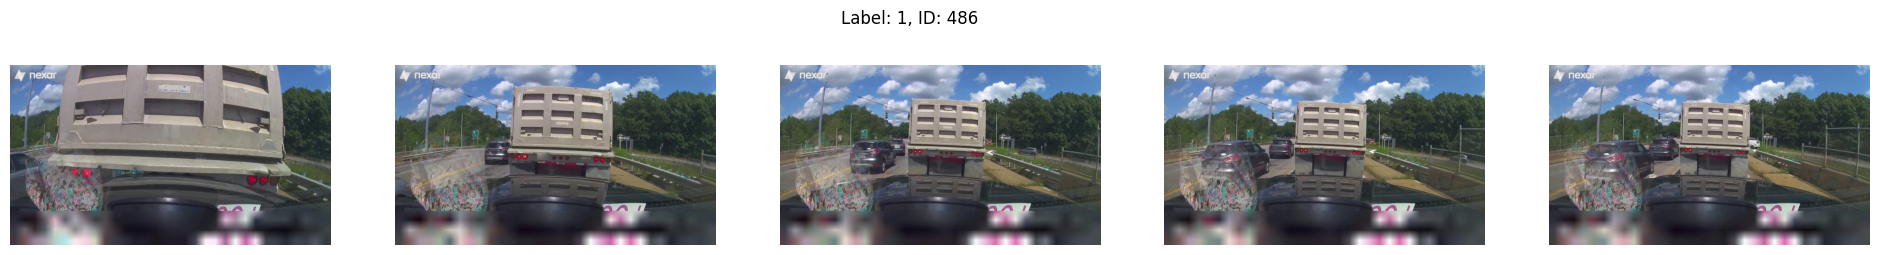

In [9]:
images, label, id = train_dataset[np.random.randint(0, len(train_dataset))]

num_images = len(images)
fig, axes = plt.subplots(1, num_images, figsize=(24, 3))

if num_images == 1:
    axes.imshow(images[0])
    axes.axis("off")
else:
    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis("off")

plt.suptitle(f"Label: {int(label)}, ID: {int(id)}")
plt.show()

In [10]:
reasoning_df = pd.read_csv("gpt4o_cot.csv", encoding="cp1252")
reasoning_dict = dict(zip(reasoning_df["id"], reasoning_df["response"]))

reasoning_df.head()

,id,label,response
0,1924,0,Analyzing the image:\n\n1. **Vehicle Positions...
1,822,1,To analyze the potential for a collision in th...
2,1429,0,To assess whether there is an immediate threat...
3,208,1,To analyze the sequence of dashcam images and ...
4,1904,0,"In this image, I will analyze potential traffi..."


#### Load Models

In [11]:
# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit",  # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit",  # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",
    "unsloth/Pixtral-12B-2409-bnb-4bit",  # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",  # Pixtral base model
    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",  # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",
    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",  # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
]  # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    # "unsloth/Llama-3.2-11B-Vision-Instruct",
    fourbit_models[0],
    load_in_4bit=True,  # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing="unsloth",  # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.3.19: Fast Mllama patching. Transformers: 4.50.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 21.964 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:30<00:00, 15.25s/it]


In [12]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,  # False if not finetuning vision layers
    finetune_language_layers=True,  # False if not finetuning language layers
    finetune_attention_modules=True,  # False if not finetuning attention layers
    finetune_mlp_modules=True,  # False if not finetuning MLP layers
    r=16,  # The larger, the higher the accuracy, but might overfit
    lora_alpha=16,  # Recommended alpha == r at least
    lora_dropout=0,
    bias="none",
    random_state=3407,
    use_rslora=False,  # We support rank stabilized LoRA
    loftq_config=None,  # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


#### Convert Datasets

In [13]:
SYSTEM_PROMPT = """
You are an expert in accident reconstruction and traffic analysis. You will analyze a sequence of dashcam images with a chain of thought reasoning to determine whether there is an immediate threat of vehicle collision. Consider each of the following factors:

1. Vehicle Positions: Identify the locations of all vehicles in each frame and how they change over time.
2. Trajectories: Determine the direction, speed, and acceleration of each vehicle by comparing their positions across frames.
3. Nearby Vehicles and Traffic: Identify surrounding vehicles, pedestrians, and any traffic congestion that could impact movement.
4. Traffic Signals: Consider whether traffic signals indicate a stop, go, or caution state and how that affects the vehicle interactions. Pay special attention on whether vehicles are vialating or obeying traffic signal rules.
5. Road Conditions and Visibility: Note any obstructions, road markings, or weather conditions that could contribute to the situation.
"""

SYSTEM_FORMAT_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""


def convert_to_conversation(images, label, id):
    reasoning = reasoning_dict.get(str(int(id)))
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": SYSTEM_PROMPT},
                {"type": "text", "text": SYSTEM_FORMAT_PROMPT},
                *[
                    {
                        "type": "image",
                        "image": image,
                    }
                    for image in images
                ],
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": f"<reasoning>\n{reasoning}\n</reasoning>\n<answer>\n{'Yes' if label else 'No'}\n</answer>",
                }
            ],
        },
    ]

    return {"messages": conversation}

In [16]:
train_converted_dataset = [
    convert_to_conversation(images, label, id)
    for images, label, id in tqdm(train_dataset)
]
val_converted_dataset = [
    convert_to_conversation(images, label, id)
    for images, label, id in tqdm(val_dataset)
]

100%|██████████| 300/300 [09:03<00:00,  1.81s/it]


In [17]:
train_converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': '\nYou are an expert in accident reconstruction and traffic analysis. You will analyze a sequence of dashcam images with a chain of thought reasoning to determine whether there is an immediate threat of vehicle collision. Consider each of the following factors:\n\n1. Vehicle Positions: Identify the locations of all vehicles in each frame and how they change over time.\n2. Trajectories: Determine the direction, speed, and acceleration of each vehicle by comparing their positions across frames.\n3. Nearby Vehicles and Traffic: Identify surrounding vehicles, pedestrians, and any traffic congestion that could impact movement.\n4. Traffic Signals: Consider whether traffic signals indicate a stop, go, or caution state and how that affects the vehicle interactions. Pay special attention on whether vehicles are vialating or obeying traffic signal rules.\n5. Road Conditions and Visibility: Note any obstructions, road ma

#### Training

In [18]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Extract Yes/No from <answer> tags
    predicted_labels = []
    for pred in decoded_preds:
        match = re.search(r"<answer>\s*(Yes|No)\s*</answer>", pred)
        if match:
            predicted_labels.append(1 if match.group(1).strip() == "Yes" else 0)
        else:
            # Default to 0 if no clear answer found
            predicted_labels.append(0)

    # Convert to numpy arrays for metric calculation
    predicted_labels = np.array(predicted_labels)
    true_labels = labels

    accuracy = (predicted_labels == true_labels).mean()
    return {
        "accuracy": accuracy,
    }

In [39]:
torch.cuda.empty_cache()

In [31]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model)  # Enable for training!

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),  # Must use!
    train_dataset=train_converted_dataset,
    eval_dataset=val_converted_dataset,
    args=SFTConfig(
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate=2e-4,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        logging_steps=1,
        evaluation_strategy="steps",  # Enable evaluation
        eval_steps=5,  # Evaluate every 5 steps
        save_strategy="steps",
        save_steps=5,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",  # For Weights and Biases
        # You MUST put the below items for vision finetuning:
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=1,
        max_seq_length=2048,
    ),
)

/home/frank/nexcar-challenge/.venv/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/frank/nexcar-challenge/.venv/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [32]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 21.964 GB.
20.717 GB of memory reserved.


In [34]:
trainer_stats = None
try:
    trainer_stats = trainer.train(resume_from_checkpoint=True)
except RuntimeError as e:
    print("Runtime error:", e)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,200 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 67,174,400/11,000,000,000 (0.61% trained)


Step,Training Loss,Validation Loss
25,0.716000,0.662267
30,0.631400,0.656476


In [ ]:
eval_results = trainer.evaluate()
print(f"\nFinal validation loss: {eval_results['eval_loss']:.4f}")

In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

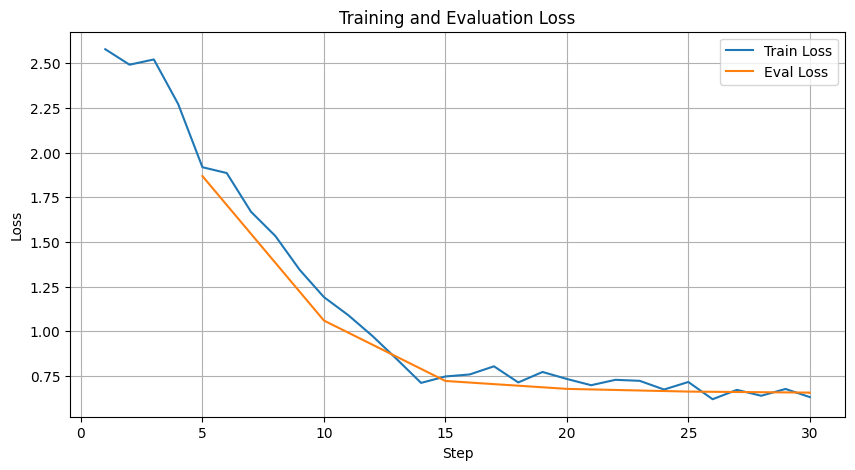

In [42]:
log_history = trainer.state.log_history

train_steps = [log["step"] for log in log_history if "loss" in log]
train_loss = [log["loss"] for log in log_history if "loss" in log]
eval_steps = [log["step"] for log in log_history if "eval_loss" in log]
eval_loss = [log["eval_loss"] for log in log_history if "eval_loss" in log]

plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Eval Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid(True)
plt.savefig("training_loss_llama3.2.png")
plt.show()

#### Save Model

In [37]:
model.save_pretrained(f"pretrained/finetuned_llama_3.2/")
tokenizer.save_pretrained(f"pretrained/finetuned_llama_3.2/")

[]

#### Generate Test Predictions

In [45]:
FastVisionModel.for_inference(model)  # Enable for inference!

image, label, id = val_dataset[0]
print(f"id: {id}, label: {label}")

conversation = convert_to_conversation(image, label, id)

input_text = tokenizer.apply_chat_template(
    conversation["messages"], add_generation_prompt=True
)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")


text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=text_streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.5,
    min_p=0.1,
)

<|begin_of_text|><|start_header_id|>user<|end_header_id|>


You are an expert in accident reconstruction and traffic analysis. You will analyze a sequence of dashcam images with a chain of thought reasoning to determine whether there is an immediate threat of vehicle collision. Consider each of the following factors:

1. Vehicle Positions: Identify the locations of all vehicles in each frame and how they change over time.
2. Trajectories: Determine the direction, speed, and acceleration of each vehicle by comparing their positions across frames.
3. Nearby Vehicles and Traffic: Identify surrounding vehicles, pedestrians, and any traffic congestion that could impact movement.
4. Traffic Signals: Consider whether traffic signals indicate a stop, go, or caution state and how that affects the vehicle interactions. Pay special attention on whether vehicles are vialating or obeying traffic signal rules.
5. Road Conditions and Visibility: Note any obstructions, road markings, or weather condit

Exception ignored in: <function ExactWeakKeyDictionary.__setitem__.<locals>.<lambda> at 0x7f628a7274c0>
Traceback (most recent call last):
  File "/home/frank/nexcar-challenge/.venv/lib/python3.11/site-packages/torch/_dynamo/utils.py", line 589, in <lambda>
    self.refs[idx] = weakref.ref(key, lambda ref: self._remove_id(idx))

KeyboardInterrupt: 


<reasoning>
To analyze this sequence of images for potential threats of vehicle collision, let’s break it down:

**1. Vehicle Positions:**

- The vehicle at the back starts moving out of the crosswalk. This suggests a potential interaction with pedestrians or other vehicles that might be nearby but not visible in this frame.

**2. Trajectories:**

- The vehicle ahead remains stationary, likely waiting to clear the crosswalk for pedestrians or pedestrians to cross before it proceeds.
- The vehicle at the back seems to be moving into a lane or intersection area, increasing the risk of collisions with pedestrians or other vehicles in this zone.

**


In [ ]:
test_csv_path = f"{DATA_DIR}/test.csv"
test_videos_folder = f"{DATA_DIR}/test/"
test_set = ImageDataset(df, train_videos_folder, transform=transform)

In [ ]:
results = []

for image, target, id in test_set:
    conversation = convert_to_conversation(image, label)
    input_text = tokenizer.apply_chat_template(
        conversation["messages"], add_generation_prompt=True
    )

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    output_tokens = model.generate(
        **inputs, max_new_tokens=128, use_cache=True, temperature=1.5, min_p=0.1
    )
    output_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

    # Store more detailed results
    results.append(
        {
            "id": id,
            "target": target,
            "response": output_text,
            "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        }
    )

df = pd.DataFrame(results)
output_filename = (
    f"llama_3.2_test_results_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
)
df.to_csv(output_filename, index=False)
print(f"Results saved to: {output_filename}")